In [29]:

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torchvision

In [30]:
from os.path import join as pjoin

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.5],
        [0.5]
    )
])

class LabelTransformer():
    _default_list = np.array([
    'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson',
       'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy',
       'edna_krabappel', 'homer_simpson', 'kent_brockman',
       'krusty_the_clown', 'lisa_simpson', 'marge_simpson',
       'milhouse_van_houten', 'moe_szyslak', 'ned_flanders',
       'nelson_muntz', 'principal_skinner', 'sideshow_bob'
    ])

    def __init__(self, initial_list = _default_list):
        self.initial_list = initial_list
    
    def __call__(self, val):
        if type(val) == str:
            return self.toInt(val)
        elif type(val) == int:
            return self.toStr(val)
        return None

    def toInt(self, label : str) -> int:
        return np.where(self.initial_list == label)[0][0]
    
    def toStr(self, ind : int) -> str:
        return self.initial_list[ind]

class SimpsonsDataset(Dataset):
    def __init__(self, annotations, img_dir, transform = None, label_transform = None):
        self.annotations = pd.read_csv(annotations, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.annotations.iloc[index, 0][2:])
        image = read_image(img_path)
        label = self.annotations.iloc[index, -1]
        border = np.array(list(self.annotations.iloc[index, 1:-1]))
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label, border


training_data = SimpsonsDataset(
    "dataset/annotation.txt",
    img_dir='dataset',
    transform=transform,
    label_transform=LabelTransformer()
 )

images batch shape: torch.Size([9, 3, 64, 64])
Labels batch shape: torch.Size([9])
Borders batch shape: torch.Size([9, 4])


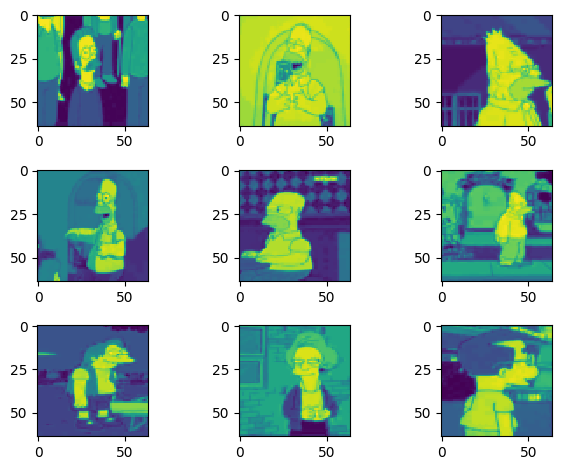

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=9, shuffle=True)

train_images, train_name, train_border = next(iter(train_dataloader))

print(f"images batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_name.size()}")
print(f"Borders batch shape: {train_border.size()}")

import matplotlib.pyplot as plt

figure = plt.figure()

for index in range(train_images.size()[0]):
    plt.subplot(3, 3, index + 1)
    plt.tight_layout()
    plt.imshow(train_images[index][0], interpolation='none')

In [32]:
class SimpsonsFullyConnectedNetwork(nn.Module):
    def __init__(self, img_size = (3, 64, 64), num_classes = 0):
        super().__init__()

        input_features = img_size[0] * img_size[1] * img_size[2]

        self.fc1 = nn.Linear(input_features, 1728)
        self.fc2 = nn.Linear(1728, 432)
        self.fc3 = nn.Linear(432, 216)
        self.fc4 = nn.Linear(216, 108)
        self.fc5 = nn.Linear(108, num_classes)

    def forward(self, x : torch.Tensor):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        x = self.fc5(x)
        return x

In [37]:
model = SimpsonsFullyConnectedNetwork(num_classes=len(LabelTransformer._default_list))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD( 
    params=model.parameters(),
    lr=0.01,
    momentum=0.9,
)

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)

def train_step():
    model.train()
    processed = 0
    running_loss = 0.
    for images, labels, borders in train_dataloader:
        processed += len(images)
        images = images.cuda()
        labels = labels.cuda()

        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
    with torch.no_grad():
        train_loss = running_loss / processed
    return train_loss.item()

def valid_step():
    model.eval()
    processed = 0
    correct_total = 0
    running_loss = 0
    with torch.no_grad():
        for images, labels, border in train_dataloader:
            processed += len(images)
            images = images.cuda()
            labels = labels.cuda()

            images = images.view(images.shape[0], -1)
            output = model(images)
            prediction = output.max(dim = 1, keepdim=True)[1]
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            loss = criterion(output, labels)
            running_loss = loss
            if processed >= 100:
                break
        valid_loss = running_loss / processed
        accuracy = correct_total / processed
        return valid_loss.item(), accuracy.item()

train_losses = []
valid_losses = []
valid_accs = []

epochs = 10
model.cuda() 

from tqdm import tqdm

for _ in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc = valid_step()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    pbar.set_description(f'Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

Avg. train/valid loss: 0.0111/0.0108: 100%|██████████| 10/10 [03:37<00:00, 21.79s/it]


Text(0, 0.5, 'Loss')

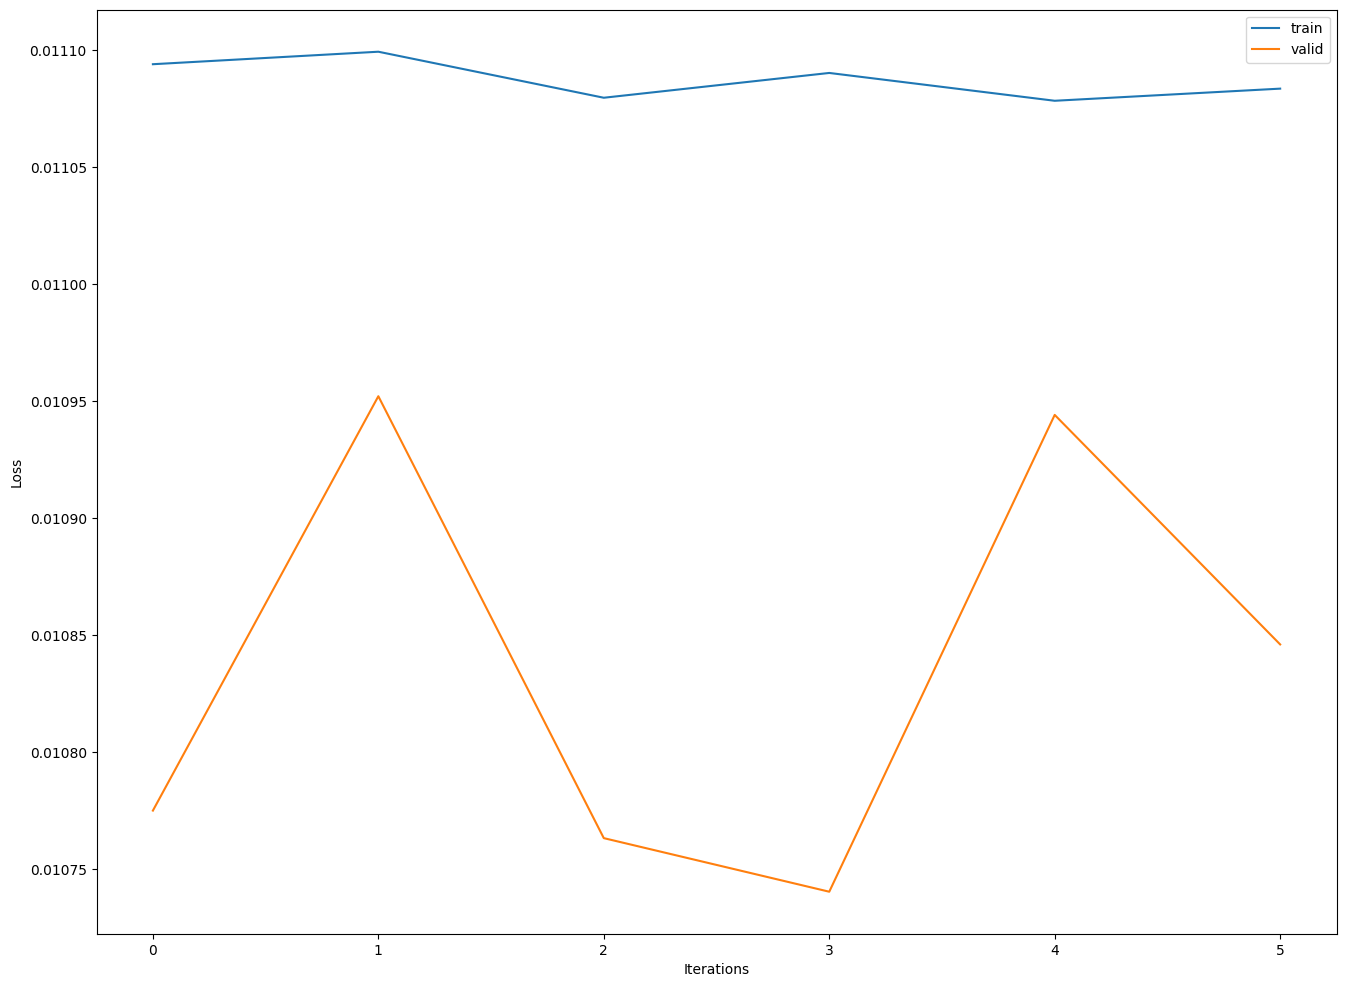

In [38]:
fig = plt.figure(figsize=(16, 12))

plt.plot(train_losses[4:], label='train')
plt.plot(valid_losses[4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

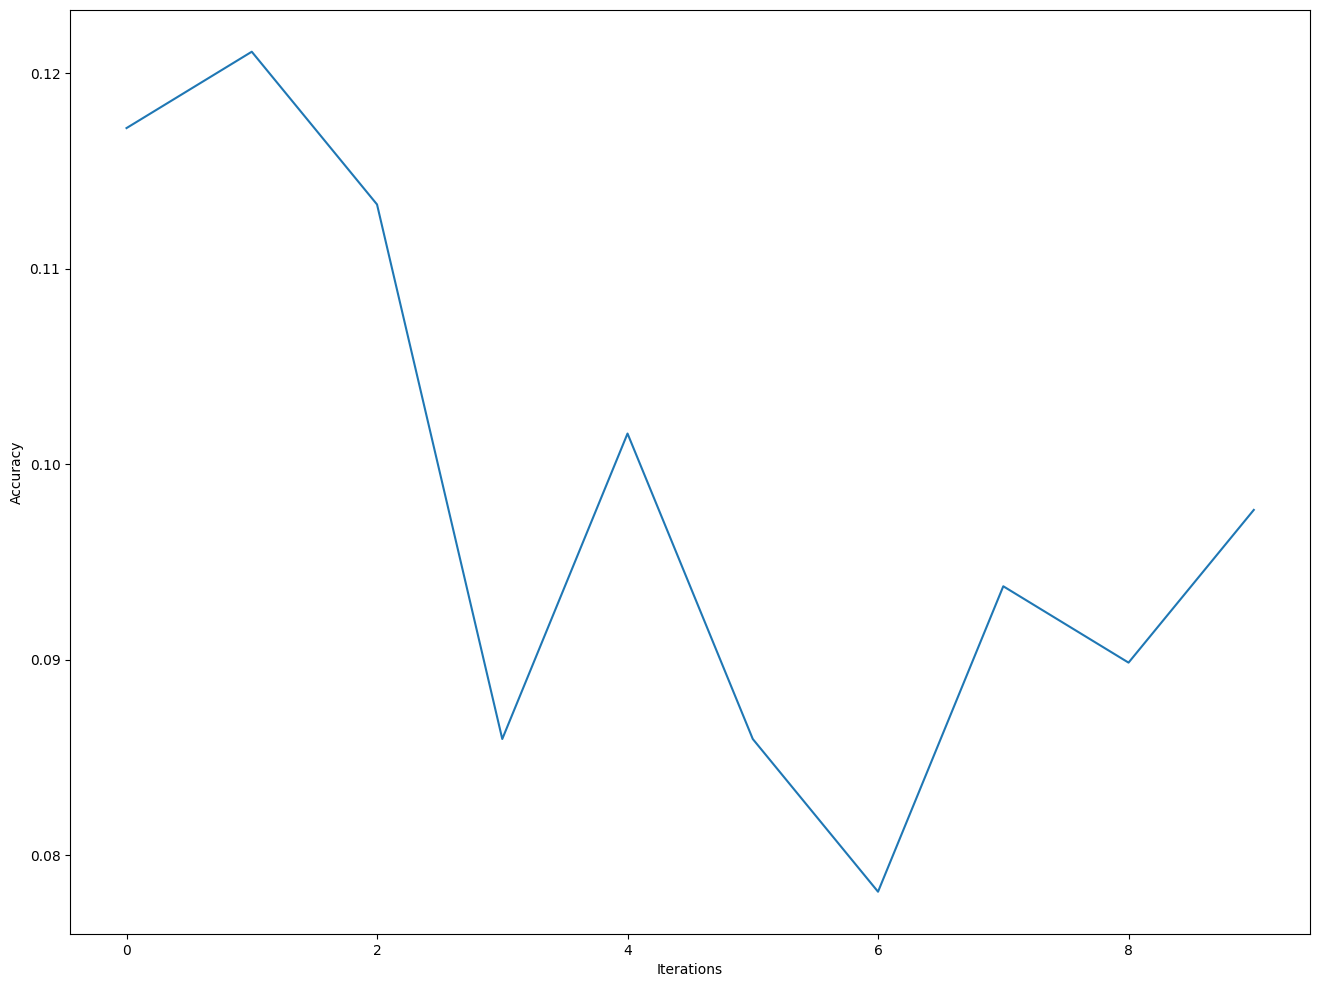

: 

In [39]:
fig = plt.figure(figsize=(16, 12))

plt.plot(valid_accs)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')